In [27]:
import xarray as xr
import numpy as np
import requests as R
import datetime as DT
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
# def getmsis (date,lat,lon,z_top):
#     Kb = 1.380649e-23 # J/K Boltzmans constant
#     homeip="83.248.102.195"
#     url="http://{}:59059/msissolar/{}/{}/{}/{}".format(homeip, date, lat, lon, z_top)
#     xxx = R.get(url).json()
#     N = np.array(xxx['n2'])+np.array(xxx['o2'])+np.array(xxx['o']) #molec m-3
#     z = np.array(xxx['z'])
#     o2 = np.array(xxx['o2'])/1e6 #to cm-3
#     T = xxx['T']
#     pres = N*Kb*T # J m-3 = N m-2 = Pa
#     xxx['p'] = pres
#     return z,T,pres

# z,T,press = getmsis("2004-06-01T12:00:00",50,100,200)
# Dates = np.array([DT.datetime(2004,1,1,12)+(i)*DT.timedelta(days=7) for i in range(int(365/7))])
# Lats = np.arange(-90,92,2.5)
# Temps = np.zeros((Lats.shape[0],Dates.shape[0],200))
# Press = np.zeros_like(Temps)
# z_top = 200 #km
# for ilat,lat in enumerate(Lats):
#     # print("latitude = {}".format(lat))
#     for idate,date in enumerate(Dates):
#         #print(date.isoformat())
#         z,T,pres = getmsis(date.isoformat(),lat,100,z_top)
#         Temps[ilat,idate] = np.array(T)
#         Press[ilat,idate] = np.array(pres)
        
# MsisT=xr.Dataset({"Temperature": (("Lats","Dates","Altitude"), Temps, {'units': 'K'}),
#                     "Pressure": (("Lats","Dates","Altitude"), Press, {'units': 'Pa'}),
#                     "Dates": (("Dates"), Dates),
#                     "Lats": (("Lats"), Lats),
#                     "Altitude": (("Altitude"),z, {'units': 'km'})})
# MsisT.to_netcdf("MsisT2004.nc")

In [29]:
MsisT=xr.load_dataset("MsisT2004.nc")
MsisT

<xarray.Dataset>
Dimensions:      (Altitude: 200, Dates: 52, Lats: 73)
Coordinates:
  * Dates        (Dates) datetime64[ns] 2004-01-01T12:00:00 ... 2004-12-23T12...
  * Lats         (Lats) float64 -90.0 -87.5 -85.0 -82.5 ... 82.5 85.0 87.5 90.0
  * Altitude     (Altitude) int64 0 1 2 3 4 5 6 ... 193 194 195 196 197 198 199
Data variables:
    Temperature  (Lats, Dates, Altitude) float64 261.1 257.2 ... 735.1 735.9
    Pressure     (Lats, Dates, Altitude) float64 9.989e+04 ... 6.02e-05

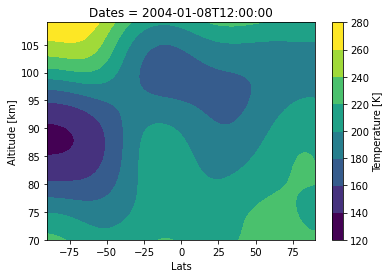

In [30]:
MsisT.Temperature.isel(
    Dates=1,Altitude=slice(70,110)
    ).plot.contourf(
        x="Lats", y="Altitude", levels=10 #np.arange(120,320,10)
        )

In [31]:
# MsisT.Temperature.isel(
#     Lats=32,Altitude=slice(70,110)
#     ).plot.contourf(
#         x="Dates",y="Altitude", levels=10, cmap=plt.cm.cividis
#         )


In [32]:
# MsisT.Pressure.isel(
#     Dates=1, Altitude=slice(0,105)
#     ).plot.contourf(
#         x="Lats", y="Altitude", 
#         cmap=plt.cm.jet,
#         levels=(10000,8000,5000,3000,1000,800,500,300,100,80,50,30,10,8,5,3,1)
#         )


In [33]:
def o_profile(Omax, Shapefactor, zmax, h, z):
    hs = h * Shapefactor
    e1 = np.exp (( zmax - z ) / hs )
    oxygen = Omax * np.exp ( 0.5 * ( 1 - (z -  zmax) / hs - e1 ))
    return oxygen

In [34]:
# testatm = MsisT.sel(Dates='2004-03-11', Lats=0, method='nearest').sel(Altitude=slice(60,110))

# R_gas = 8.31446261815324 #J⋅K−1⋅mol−1 OR kg⋅m2⋅s−2⋅K−1⋅mol−1
# g = 9.81 #m s-2
# M_air = 28.9 #g mol-1
# H_scale = R_gas/M_air/g * testatm.sel(Altitude=90).Temperature.values # km

# p = testatm.Pressure
# O = o_profile(8e11, 1.1, 98, H_scale, testatm.Altitude)
# T = testatm.Temperature

# def oh_profile(O, T, p):
#     return p * O/ T**3.4

# oh_profile(O, T, p).plot(y='Altitude')

Scale height at z_Opeak= [5.77940183]


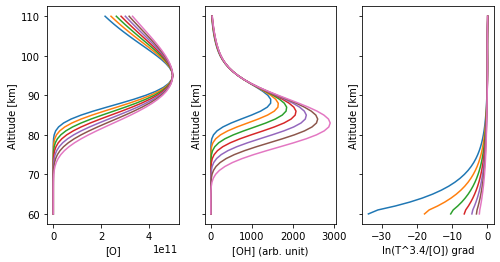

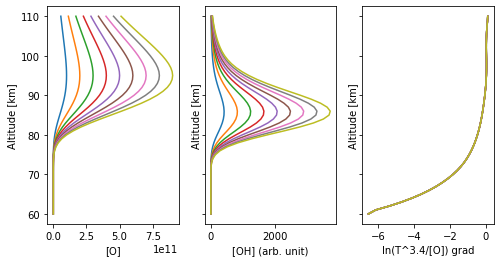

In [40]:
testatm = MsisT.sel(Dates='2004-03-11', Lats=0, method='nearest').sel(Altitude=slice(60,110))

R_gas = 8.31446261815324 #J⋅K−1⋅mol−1 OR kg⋅m2⋅s−2⋅K−1⋅mol−1
g = 9.81 #m s-2
M_air = 28.9 #g mol-1
z_opeak = 95 #km
H_scale = R_gas/M_air/g * testatm.sel(Altitude=z_opeak).Temperature.values #km
print ("Scale height at z_Opeak= {}".format(H_scale))
p = testatm.Pressure
T = testatm.Temperature

def oh_profile(O, T, p):
    return p * O/ T**3.4

fig, ax = plt.subplots(1,3, sharey=True, figsize=(8,4))
for sf in np.arange(1,1.6,0.1):
    O = o_profile(Omax=5e11, Shapefactor=sf, zmax=z_opeak, h=H_scale, z=testatm.Altitude).rename('[O]')
    OH = oh_profile(O, T, p).rename('[OH] (arb. unit)')
    O.plot(y='Altitude', ax=ax[0], label=sf.round(1))
    OH.plot(y='Altitude', ax=ax[1])
    (T**3.4/O).pipe(np.log).differentiate(coord='Altitude').rename('ln(T^3.4/[O]) grad').plot(y='Altitude', ax=ax[2])
# ax[0].legend(title='sf')
[ax[i].set_title('') for i in range(len(ax))]

fig, ax = plt.subplots(1,3, sharey=True, figsize=(8,4))
for omax in np.arange(1e11,10e11,1e11):
    O = o_profile(Omax=omax, Shapefactor=1.3, zmax=z_opeak, h=H_scale, z=testatm.Altitude).rename('[O]')
    OH = oh_profile(O, T, p).rename('[OH] (arb. unit)')
    O.plot(y='Altitude', ax=ax[0])
    OH.plot(y='Altitude', ax=ax[1])
    (T**3.4/O).pipe(np.log).differentiate(coord='Altitude').rename('ln(T^3.4/[O]) grad').plot(y='Altitude', ax=ax[2])
[ax[i].set_title('') for i in range(len(ax))]

plt.show()

Pure Oxygen Model (Chapman reactions)

(Note: althouth HOx accounts for >90% and Ox accouts for <5% of the O3 destruction in the mesosphere, we are here looking at the dependency of [O] profile on Ly-a, thus a simple Chapman scheme is enough to see the relative difference made, rather than the absolute values.)

O2 -->(J_O2) O + O

O3 -->(J_O3) O + O2

O + O2 + M -->(k2) O3 + M

O + O3 -->(k3) O2 + O2

Steady state

[O] = (2*J_O2[O2] + J_O3[O3])/(k2[M][O2] + k3[O3])

In [51]:
O3_sb = np.array([8.0e11, 7.7e11, 7.5e11, 2.2e12, 4.8e12, 4.9e12, 3.1e12, 1.3e12, 3.9e11, 1.2e11, 4.1e10, 1.5e10, 5.7e9, 2.2e9, 6.0e8, 1.3e8, 9.3e7, 1.7e8, 4.0e7, 5.7e6, 2.5e6])
z_sb =  np.arange(0,105,5)
O3_sb = xr.DataArray(O3_sb, coords=(z_sb,), dims=('z',), name='O3')
O3_sb.interp(z=testatm.Altitude)

<xarray.DataArray 'O3' (Altitude: 51)>
array([5.700e+09, 5.000e+09, 4.300e+09, 3.600e+09, 2.900e+09, 2.200e+09,
       1.880e+09, 1.560e+09, 1.240e+09, 9.200e+08, 6.000e+08, 5.060e+08,
       4.120e+08, 3.180e+08, 2.240e+08, 1.300e+08, 1.226e+08, 1.152e+08,
       1.078e+08, 1.004e+08, 9.300e+07, 1.084e+08, 1.238e+08, 1.392e+08,
       1.546e+08, 1.700e+08, 1.440e+08, 1.180e+08, 9.200e+07, 6.600e+07,
       4.000e+07, 3.314e+07, 2.628e+07, 1.942e+07, 1.256e+07, 5.700e+06,
       5.060e+06, 4.420e+06, 3.780e+06, 3.140e+06, 2.500e+06,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan])
Coordinates:
    z         (Altitude) int64 60 61 62 63 64 65 66 ... 105 106 107 108 109 110
    Lats      float64 0.0
  * Altitude  (Altitude) int64 60 61 62 63 64 65 66 ... 105 106 107 108 109 110